# Example Code for the Optimum Filters
-----
Import `qetpy` and other necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
from pprint import pprint

## Use `QETpy` to generate some simulated TES noise

We can use `qetpy.sim.TESnoise` to help create a simulated PSD with characteristic TES parameters.

In [2]:
fs = 625e3
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(r0=0.03)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

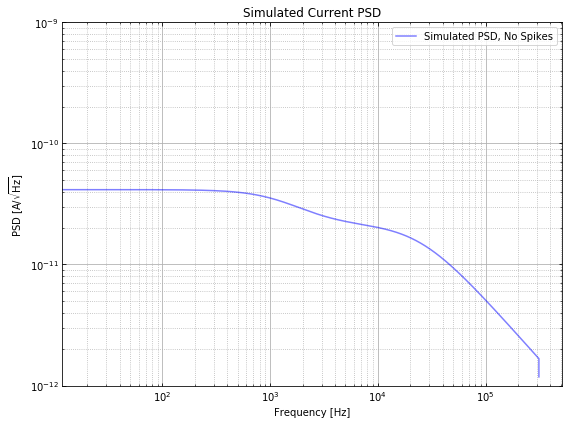

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(f_fold, psd_sim_fold**0.5, color="blue", alpha=0.5, label="Simulated PSD, No Spikes")
ax.set_ylim(1e-12,1e-9)
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc="best")
ax.set_title("Simulated Current PSD")
ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()

With a PSD, we can use `qetpy.gen_noise` to generate random noise from the PSD (assuming the frequencies are uncorrelated). Then, we will create an example pulse.

In [4]:
# create a template
pulse_amp = 1e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

# use the PSD to create an example trace to fit
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 100)*pulse_amp # note the shift we have added, 160 us

## Fit a single pulse with `OptimumFilter`

With a pulse created, let's use the `qetpy.OptimumFilter` class to run different Optimum Filters.

In [5]:
qp.OptimumFilter?

Below, we print the different methods available in `qetpy.OptimumFilter`. In this notebook, we will demo the `ofamp_nodelay`, `ofamp_withdelay`, `ofamp_pileup_iterative`, and `update_signal` methods. It is highly recommend to read the documentation for the other methods, as there are many useful ones!

In [6]:
method_list = sorted([func for func in dir(qp.OptimumFilter) if callable(getattr(qp.OptimumFilter, func)) and not func.startswith("__")])
pprint(method_list)

['chi2_lowfreq',
 'chi2_nopulse',
 'energy_resolution',
 'ofamp_baseline',
 'ofamp_nodelay',
 'ofamp_pileup_iterative',
 'ofamp_pileup_stationary',
 'ofamp_withdelay',
 'time_resolution',
 'update_signal']


Let's run the Optimum Filter without and with a time-shifting degree of freedom.

In [7]:
OF = qp.OptimumFilter(signal, template, psd_sim, fs) # initialize the OptimumFilter class
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay()

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")

No Delay Fit: amp = -0.04 μA, χ^2 = 210399.75
With Delay Fit: amp = 1.00 μA, t_0 = 160.0 μs, χ^2 = 32407.30


Since we have added a 160 us shift, we see that the "with delay" optimum filter fit the time-shift perfectly, and the chi-squared is very close to the number of degrees of freedom (32768), as we would expect for a good fit.

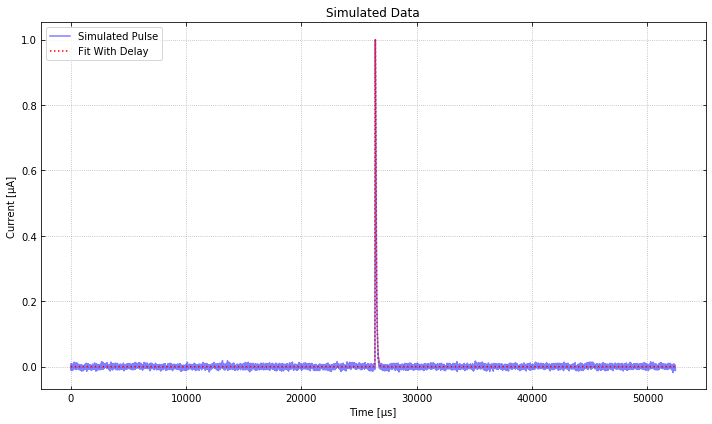

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t*1e6, signal*1e6, label="Simulated Pulse", color="blue", alpha=0.5)
ax.plot(t*1e6, amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6, 
        label="Fit With Delay", color="red", linestyle="dotted")
ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time [μs]")
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

## Add a pileup pulse and fit with `OptimumFilter`

Let's now add a second (pileup) pulse in order to see how we can use `ofamp_pileup_iterative`.

In [9]:
pileup = signal + np.roll(template, 10000)*pulse_amp

OF.update_signal(pileup) # update the signal in order to fit a new trace
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=300)
amp_pileup, t0_pileup, chi2_pileup = OF.ofamp_pileup_iterative(amp_withdelay, t0_withdelay)

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")
print(f"Pileup Fit: amp = {amp_pileup*1e6:.2f} μA, t_0 = {t0_pileup*1e6} μs, χ^2 = {chi2_pileup:.2f}")

With Delay Fit: amp = 1.00 μA, t_0 = 160.0 μs, χ^2 = 209503.04
Pileup Fit: amp = 1.00 μA, t_0 = 16000.0 μs, χ^2 = 32407.28


As expected, the pileup optimum filter fit the data very well, as we can see from the chi-squared above.

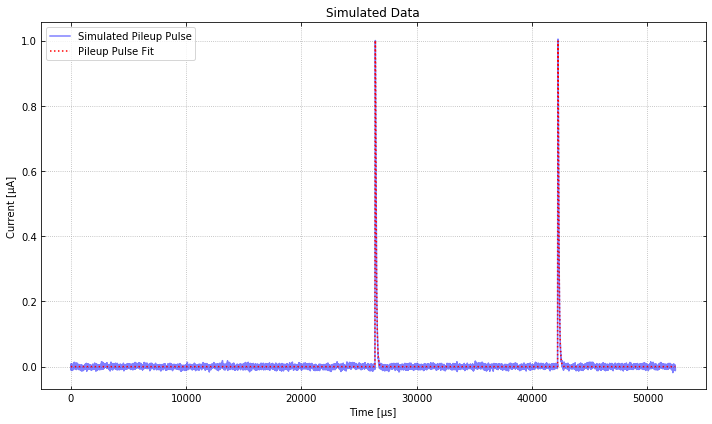

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t*1e6, pileup*1e6, label="Simulated Pileup Pulse", color="blue", alpha=0.5)
ax.plot(t*1e6, amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6 + \
        amp_pileup*np.roll(template, int(t0_pileup*fs))*1e6, 
        label="Pileup Pulse Fit", color="red", linestyle="dotted")

ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time [μs]")
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

## Nonlinear Fitting

What about when we do not have a template? The `qetpy.OFnonlin` class has been written to fit the fall times as well, which is useful for cases where we do not have a template, or we know that the template will not match the data well.

In [11]:
pulse_amp = 1e-6
tau_f = 160e-6
tau_r = 20e-6

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 100)*pulse_amp

We can try using our "bad" template (with a 66 us fall time), but we will see that the chi-squared indicates a non-ideal fit.

In [12]:
OF.update_signal(signal) # update the signal in order to fit a new trace
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=300)

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6:.2f} μs, χ^2 = {chi2_withdelay:.2f}")

With Delay Fit: amp = 1.07 μA, t_0 = 163.20 μs, χ^2 = 72524.20


Let's use `qetpy.OFnonlin` to do the fit. To help visualize the fit, we will use the parameter `lgcplot=True` to plot the fit in frequency domain and time domain

In [13]:
qp.OFnonlin?

In [14]:
qp.OFnonlin.fit_falltimes?

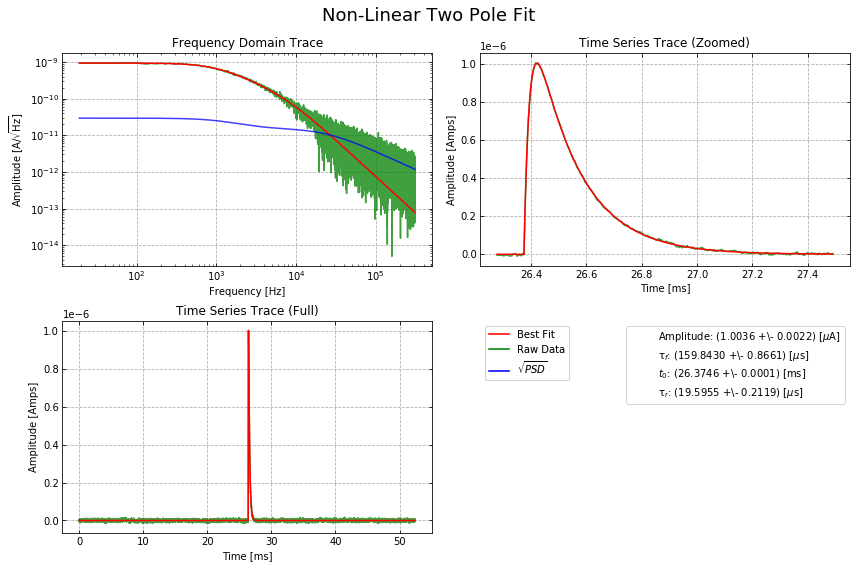

In [15]:
nonlinof = qp.OFnonlin(psd_sim, fs, template=None)
params, error, _, chi2_nonlin, success = nonlinof.fit_falltimes(signal, npolefit=2, lgcfullrtn=True, lgcplot=True)

In [16]:
print(f"Nonlinear fit: χ^2 = {chi2_nonlin * (len(nonlinof.data)-nonlinof.dof):.2f}")

Nonlinear fit: χ^2 = 32719.95


And we see that the fit using `qetpy.OFnonlin` is great! The chi-squared is near the number of degrees of freedom (32768), which indicates that we have a good fit.

For further documentation on the different fitting functions, please visit https://qetpy.readthedocs.io/en/latest/qetpy.core.html#module-qetpy.core._fitting.